# Importing

In [1]:
# Importando bibliotecas necessárias
import os
import sys
import builtins 
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import seaborn as sns

import statistics as stats
# This helps auto print out the items without explixitly using 'print'
InteractiveShell.ast_node_interactivity = "all" 
%matplotlib inline


from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.types import StringType, NumericType
from pyspark.sql import Window
from pyspark.sql.functions import col, when, count, isnan, isnull, mean, lit, avg, desc, isnan, percentile_approx, concat_ws, sum as ps_sum, rand, approx_count_distinct, round as ps_round, month, expr
from pyspark.ml.stat import Correlation
import matplotlib.pyplot as plt
from pyspark.ml.feature import (StringIndexer, OneHotEncoder, FeatureHasher, VectorAssembler, StandardScaler)
from pyspark import StorageLevel
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import *

In [2]:
spark = SparkSession.builder \
    .appName("Airline Delay Estimatoor") \
    .master("local[*]") \
    .config("spark.sql.shuffle.partitions", 200) \
    .config("spark.driver.memory",   "8g") \
    .config("spark.executor.memory", "8g")\
    .getOrCreate()

# Converter em para parquet

EXECUTE ESSA CÉLULA APENAS A PRIMEIRA VEZ PARA COVERTER O DATASET EM PARQUET!!!!!!!!

In [3]:
csv_path = "datasets/airline.csv.shuffle"

df_csv = spark.read.csv(csv_path, header=True, inferSchema=True)
df_csv.write.mode("overwrite")\
      .partitionBy("Year","Month")\
      .parquet("datasets/parquet/flights")

Número de linhas no DataFrame: 123534969


Após a primeira execução, rode a partir daqui pra baixo

# Lendo Parquet

In [3]:
df_raw = spark.read.parquet("datasets/parquet/flights")

num_linhas = df_raw.count()
print(f"Número de linhas no DataFrame: {num_linhas}")

Número de linhas no DataFrame: 123534969


In [4]:
print('Shape of the dataset: ', (df_raw.count(), len(df_raw.columns)))

Shape of the dataset:  (123534969, 29)


Dados relevantes sobre o dataset: Os dados presentes nele são desde Outubro de 1987 até April de 2008. Possui mais de 120 milhões de linhas de dados coletados. É possível analizar antes e depois do 11/09/2001.



# Data Analysis

| # | Nome da Coluna | Descrição |
|---|----------------|-----------|
| 1 | **Year** | Ano do voo (1987 – 2008) |
| 2 | **Month** | Mês (1 – 12) |
| 3 | **DayofMonth** | Dia do mês (1 – 31) |
| 4 | **DayOfWeek** | Dia da semana (1 = Segunda … 7 = Domingo) |
| 5 | **DepTime** | Hora real de partida (local, hhmm) |
| 6 | **CRSDepTime** | Hora programada de partida (local, hhmm) |
| 7 | **ArrTime** | Hora real de chegada (local, hhmm) |
| 8 | **CRSArrTime** | Hora programada de chegada (local, hhmm) |
| 9 | **UniqueCarrier** | Código único da companhia aérea |
| 10 | **FlightNum** | Número do voo |
| 11 | **TailNum** | Matrícula (tail number) da aeronave |
| 12 | **ActualElapsedTime** | Tempo total real de voo (min) |
| 13 | **CRSElapsedTime** | Tempo total programado (min) |
| 14 | **AirTime** | Tempo em voo (min) |
| 15 | **ArrDelay** | Atraso na chegada (min) |
| 16 | **DepDelay** | Atraso na partida (min) |
| 17 | **Origin** | Aeroporto de origem (código IATA) |
| 18 | **Dest** | Aeroporto de destino (código IATA) |
| 19 | **Distance** | Distância da rota (milhas) |
| 20 | **TaxiIn** | Tempo de táxi após pouso (min) |
| 21 | **TaxiOut** | Tempo de táxi antes da decolagem (min) |
| 22 | **Cancelled** | Voo cancelado? (1 = sim, 0 = não) |
| 23 | **CancellationCode** | Motivo do cancelamento (A = companhia, B = clima, C = NAS, D = segurança) |
| 24 | **Diverted** | Voo alternado? (1 = sim, 0 = não) |
| 25 | **CarrierDelay** | Atraso atribuído à companhia (min) |
| 26 | **WeatherDelay** | Atraso por condições climáticas (min) |
| 27 | **NASDelay** | Atraso por Sistema Nacional de Espaço Aéreo (min) |
| 28 | **SecurityDelay** | Atraso por questões de segurança (min) |
| 29 | **LateAircraftDelay** | Atraso causado por chegada tardia da aeronave (min) |

### Entendendo o básico sobre o dataset

In [5]:
df_raw.printSchema()

root
 |-- ActualElapsedTime: string (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- ArrDelay: string (nullable = true)
 |-- ArrTime: string (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- CRSElapsedTime: string (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- CarrierDelay: string (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DepDelay: string (nullable = true)
 |-- DepTime: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: string (nullable = true)
 |-- Diverted: integer (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- LateAircraftDelay: string (nullable = true)
 |-- NASDelay: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- SecurityDelay: string (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- TaxiIn: string (nullabl

In [6]:
print('Columns overview')
pd.DataFrame(df_raw.dtypes, columns = ['Column Name','Data type'])

Columns overview


,Column Name,Data type
0,ActualElapsedTime,string
1,AirTime,string
2,ArrDelay,string
3,ArrTime,string
4,CRSArrTime,int
5,CRSDepTime,int
6,CRSElapsedTime,string
7,CancellationCode,string
8,Cancelled,int
9,CarrierDelay,string


In [7]:
df_raw.show(10)

+-----------------+-------+--------+-------+----------+----------+--------------+----------------+---------+------------+---------+----------+--------+-------+----+--------+--------+---------+-----------------+--------+------+-------------+-------+------+-------+-------------+------------+----+-----+
|ActualElapsedTime|AirTime|ArrDelay|ArrTime|CRSArrTime|CRSDepTime|CRSElapsedTime|CancellationCode|Cancelled|CarrierDelay|DayOfWeek|DayofMonth|DepDelay|DepTime|Dest|Distance|Diverted|FlightNum|LateAircraftDelay|NASDelay|Origin|SecurityDelay|TailNum|TaxiIn|TaxiOut|UniqueCarrier|WeatherDelay|Year|Month|
+-----------------+-------+--------+-------+----------+----------+--------------+----------------+---------+------------+---------+----------+--------+-------+----+--------+--------+---------+-----------------+--------+------+-------------+-------+------+-------+-------------+------------+----+-----+
|              147|    103|      15|   1953|      1938|      1700|           158|            N

In [8]:
df_raw.describe()

DataFrame[summary: string, ActualElapsedTime: string, AirTime: string, ArrDelay: string, ArrTime: string, CRSArrTime: string, CRSDepTime: string, CRSElapsedTime: string, CancellationCode: string, Cancelled: string, CarrierDelay: string, DayOfWeek: string, DayofMonth: string, DepDelay: string, DepTime: string, Dest: string, Distance: string, Diverted: string, FlightNum: string, LateAircraftDelay: string, NASDelay: string, Origin: string, SecurityDelay: string, TailNum: string, TaxiIn: string, TaxiOut: string, UniqueCarrier: string, WeatherDelay: string, Year: string, Month: string]

## Tratamento de valores nulos e cast

Os valores nulos ainda não estão tratados, como o cast ainda não foi feito, não sabemos quais dados são realmente nulos como NA, NaN e Null.

### Utils

In [9]:
def show_null(df_raw, opt = 1, chuncks = 10):
    try:
        spark.range(1).count()
    except Exception as e:
        print("Spark morto:", e)

    string_columns = [f.name for f in df_raw.schema.fields if isinstance(f.dataType, StringType)]
    num_cols   = [f.name for f in df_raw.schema if isinstance(f.dataType, NumericType)]
    null_labels = ["NULL", "NA", "None", ""]
    exprs = []
    
    for c in df_raw.columns:
        base = col(c).isNull()
        if c in num_cols:
            base = base | isnan(col(c))
        if opt == 1 and c in string_columns:
            base = base | col(c).isin(null_labels)
        exprs.append(ps_sum(base.cast("int")).alias(c))

    null_df = df_raw.agg(*exprs)      
    null_counts = null_df.first().asDict()

    total = df_raw.count()
    perc = {k: builtins.round(v/total*100,2) for k, v in null_counts.items()}
    ordenado = sorted(perc.items(), key=lambda x: x[1], reverse=True)

    null_df.show()
    # Visualização da porcentagem
    for i in range(0, len(ordenado), chuncks):
        for colname, p in ordenado[i:i+chuncks]:
            print(f"{colname:25}: {p}%  ({null_counts[colname]})")
        print('-'*40)

### Realizando o casting e reprensentando os dados nulos (ex.: NA, '', NULL e None) como o objeto especial None, indicando a ausência de valor

In [10]:
# Separando as colunas numéricas para tratamento
columns_to_int = ["ActualElapsedTime", "AirTime", "ArrDelay", "CRSElapsedTime", "DepDelay",
    "Distance", "TaxiIn", "TaxiOut", "CarrierDelay", "WeatherDelay",
    "NASDelay", "SecurityDelay", "LateAircraftDelay", "DepTime", "ArrTime"
]

# Tratando colunas, convertendo elas para dado numérico
# Neste caso Int
for column in columns_to_int:
    df_raw = df_raw.withColumn(
        column,
        when(col(column).isin('', 'NA', 'NULL', 'None'), None)
        .otherwise(col(column).cast(IntegerType()))
    )

# Facilitando a compreensão de voos com delay
df_raw = df_raw.withColumn("IsArrDelay", when(col("ArrDelay") > 0, 1).otherwise(0))
df_raw = df_raw.withColumn("IsDepDelay", when(col("DepDelay") > 0, 1).otherwise(0))
df_raw.show(10)

+-----------------+-------+--------+-------+----------+----------+--------------+----------------+---------+------------+---------+----------+--------+-------+----+--------+--------+---------+-----------------+--------+------+-------------+-------+------+-------+-------------+------------+----+-----+----------+----------+
|ActualElapsedTime|AirTime|ArrDelay|ArrTime|CRSArrTime|CRSDepTime|CRSElapsedTime|CancellationCode|Cancelled|CarrierDelay|DayOfWeek|DayofMonth|DepDelay|DepTime|Dest|Distance|Diverted|FlightNum|LateAircraftDelay|NASDelay|Origin|SecurityDelay|TailNum|TaxiIn|TaxiOut|UniqueCarrier|WeatherDelay|Year|Month|IsArrDelay|IsDepDelay|
+-----------------+-------+--------+-------+----------+----------+--------------+----------------+---------+------------+---------+----------+--------+-------+----+--------+--------+---------+-----------------+--------+------+-------------+-------+------+-------+-------------+------------+----+-----+----------+----------+
|              147|    103| 

In [11]:
df_raw.printSchema()

root
 |-- ActualElapsedTime: integer (nullable = true)
 |-- AirTime: integer (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- ArrTime: integer (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- CRSElapsedTime: integer (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- CarrierDelay: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- Diverted: integer (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- LateAircraftDelay: integer (nullable = true)
 |-- NASDelay: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- SecurityDelay: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- TaxiIn: int

### Nulos antes do tratamento

In [12]:
show_null(df_raw)

+-----------------+--------+--------+-------+----------+----------+--------------+----------------+---------+------------+---------+----------+--------+-------+----+--------+--------+---------+-----------------+--------+------+-------------+--------+--------+--------+-------------+------------+----+-----+----------+----------+
|ActualElapsedTime| AirTime|ArrDelay|ArrTime|CRSArrTime|CRSDepTime|CRSElapsedTime|CancellationCode|Cancelled|CarrierDelay|DayOfWeek|DayofMonth|DepDelay|DepTime|Dest|Distance|Diverted|FlightNum|LateAircraftDelay|NASDelay|Origin|SecurityDelay| TailNum|  TaxiIn| TaxiOut|UniqueCarrier|WeatherDelay|Year|Month|IsArrDelay|IsDepDelay|
+-----------------+--------+--------+-------+----------+----------+--------------+----------------+---------+------------+---------+----------+--------+-------+----+--------+--------+---------+-----------------+--------+------+-------------+--------+--------+--------+-------------+------------+----+-----+----------+----------+
|          25

### Tratamento de dados nulos em colunas categóricas
| # | Nome da Coluna | Descrição |
|---|----------------|-----------|
| 9 | **UniqueCarrier** | Código único da companhia aérea |
| 11 | **TailNum** | Matrícula (tail number) da aeronave |
| 17 | **Origin** | Aeroporto de origem (código IATA) |
| 18 | **Dest** | Aeroporto de destino (código IATA) |
| 23 | **CancellationCode** | Motivo do cancelamento (A = companhia, B = clima, C = NAS, D = segurança) |

In [13]:
string_columns = [f.name for f in df_raw.schema.fields if isinstance(f.dataType, StringType)]
null_labels = ["NULL", "NA", "None", ""]

print(string_columns)

# Normalizando nulos em colunas categóricas
for c in string_columns:
    df_raw = df_raw.withColumn(
        c,
        when(col(c).isin(null_labels), None).otherwise(col(c))
    )


['CancellationCode', 'Dest', 'Origin', 'TailNum', 'UniqueCarrier']


### Tratando dados ausentes em colunas sinalizadoras

| # | Nome da Coluna | Descrição |
|---|----------------|-----------|
| 11 | **TailNum** | Matrícula (tail number) da aeronave |
 14 | **AirTime** | Tempo em voo (min) |
| 12 | **ActualElapsedTime** | Tempo total real de voo (min) |
| 20 | **TaxiIn** | Tempo de táxi após pouso (min) |
| 21 | **TaxiOut** | Tempo de táxi antes da decolagem (min) |
| 25 | **CarrierDelay** | Atraso atribuído à companhia (min) |
| 26 | **WeatherDelay** | Atraso por condições climáticas (min) |
| 27 | **NASDelay** | Atraso por Sistema Nacional de Espaço Aéreo (min) |
| 28 | **SecurityDelay** | Atraso por questões de segurança (min) |
| 29 | **LateAircraftDelay** | Atraso causado por chegada tardia da aeronave (min) |

In [14]:
cols_flag = ["CarrierDelay","WeatherDelay","NASDelay",
             "SecurityDelay","LateAircraftDelay","TaxiIn",
             "TaxiOut","AirTime","ActualElapsedTime","TailNum"]

for c in cols_flag:
    df_raw = df_raw.withColumn(f"{c}_missing", when(col(c).isNull(), 1).otherwise(0))

### Tratamento de dados nulos no dataset

In [15]:
# Tirando valores nulos de possíveis causas de delay e inserindo 0
delay_causes = ["CarrierDelay",
                "WeatherDelay",
                "NASDelay",
                "SecurityDelay",
                "LateAircraftDelay", 
                "ArrDelay", 
                "DepDelay", 
                "ArrTime", 
                "DepTime",
                "AirTime", 
                "ActualElapsedTime", 
                "CRSElapsedTime"]

df_raw = df_raw.fillna({c: 0 for c in delay_causes})

# Comportamento de encerrar o taxiamento 
# caso o voo seja cancelado ou desviado
for taxi, airport_col in [("TaxiOut", "Origin"), ("TaxiIn", "Dest")]:
    df_raw = df_raw.withColumn(
        taxi,
        when((col("Cancelled") == 1) | (col("Diverted") == 1), 0).otherwise(col(taxi))
    )

    # Inserir a mediana existente da taxa de taxi por aeroporto nos dados nulos
    w = Window.partitionBy(airport_col)
    df_raw =  df_raw.withColumn(
        taxi,
        when(col(taxi).isNull(),
             percentile_approx(col(taxi), 0.5).over(w)
        ).otherwise(col(taxi))
    )


# Tempo estipulado em dados estátisticos de voos
median_speed = 825 # velocidade média de cruzeiro Boeing 737, avião mais utilizado nos EUA

df_raw = df_raw.withColumn(
    "AirTime",
    when(col("AirTime").isNull() & (col("Cancelled") == 0) & (col("Diverted") == 0),
        (col("Distance") / median_speed * 60).cast("int")
        ).otherwise(col("AirTime"))
)

# Tempo de chegada estimada (ActualElapsedTime), caso sela nula, inserir o tempo total programado (CRSElapsedTime) se tiver
df_raw = df_raw.withColumn(
    "ActualElapsedTime",
    when(col("ActualElapsedTime").isNull(), col("CRSElapsedTime"))
    .otherwise(col("ActualElapsedTime"))
)

# Tratando Horários
df_raw = df_raw.filter(
    ~((col("DepTime").isNull() | col("ArrTime").isNull()) & (col("Cancelled") == 0))
)

# Preparando colunas categóricas para a fase de ONE HOT En.
df_raw = df_raw.fillna({
    "CancellationCode": "unknown",
    "TailNum": "UNKN",
    "Origin": "unknown",
    "Dest": "unknown",
    "UniqueCarrier": "unknown",
})

# Tratando dados faltantes ou nulos na coluna de distancia
w_route = Window.partitionBy("Origin", "Dest")
df_raw = df_raw.withColumn(
    "Distance",
    when(col("Distance").isNull(),
        percentile_approx(col("Distance"), 0.5).over(w_route)
        ).otherwise(col("Distance"))
)

df_raw = df_raw.fillna({"Distance": 0})

df_raw = df_raw.withColumn("Route", concat_ws("-", "Origin", "Dest"))

df_raw = df_raw.persist(StorageLevel.MEMORY_AND_DISK)
df_raw.count()

123534969

### Nulos após o tratamento

In [16]:
show_null(df_raw, 2)

+-----------------+-------+--------+-------+----------+----------+--------------+----------------+---------+------------+---------+----------+--------+-------+----+--------+--------+---------+-----------------+--------+------+-------------+-------+------+-------+-------------+------------+----+-----+----------+----------+--------------------+--------------------+----------------+---------------------+-------------------------+--------------+---------------+---------------+-------------------------+---------------+-----+
|ActualElapsedTime|AirTime|ArrDelay|ArrTime|CRSArrTime|CRSDepTime|CRSElapsedTime|CancellationCode|Cancelled|CarrierDelay|DayOfWeek|DayofMonth|DepDelay|DepTime|Dest|Distance|Diverted|FlightNum|LateAircraftDelay|NASDelay|Origin|SecurityDelay|TailNum|TaxiIn|TaxiOut|UniqueCarrier|WeatherDelay|Year|Month|IsArrDelay|IsDepDelay|CarrierDelay_missing|WeatherDelay_missing|NASDelay_missing|SecurityDelay_missing|LateAircraftDelay_missing|TaxiIn_missing|TaxiOut_missing|AirTime_missi

## EDA

In [17]:
p = 0.10 # Separando 10 % de cada companhia para análise
seed = 42

sample_carrier = (
    df_raw.withColumn("rand", rand(seed))
    .where(col("rand") < p)
    .drop("rand")
)

In [18]:
print("Amostra          :", sample_carrier.count())
print("Dataset completo :", df_raw.count())

Amostra          : 12355824
Dataset completo : 123534969


In [19]:
# contagem por companhia
(sample_carrier.groupBy("UniqueCarrier")
               .count()
               .orderBy("count", ascending=False)
               .show())

# atraso médio e desvio-padrão por companhia
(sample_carrier.groupBy("UniqueCarrier")
               .agg(ps_round(avg("ArrDelay"),2).alias("avg_arr"),
                    ps_round(avg("DepDelay"),2).alias("avg_dep"))
               .orderBy("avg_arr", ascending=False)
               .show())

+-------------+-------+
|UniqueCarrier|  count|
+-------------+-------+
|           DL|1656186|
|           WN|1598058|
|           AA|1498758|
|           US|1407194|
|           UA|1329363|
|           NW|1030860|
|           CO| 813544|
|           MQ| 395565|
|           TW| 375352|
|           HP| 364666|
|           OO| 308757|
|           AS| 289253|
|           XE| 235123|
|           EV| 169160|
|           OH| 146318|
|           FL| 126276|
|           EA|  92360|
|           PI|  87084|
|           YV|  85277|
|           B6|  81192|
+-------------+-------+
only showing top 20 rows

+-------------+-------+-------+
|UniqueCarrier|avg_arr|avg_dep|
+-------------+-------+-------+
|           YV|  11.05|  12.54|
|           EV|  10.39|  13.07|
|           PI|  10.29|   9.51|
|           B6|   9.65|   11.1|
|           FL|   9.27|  10.11|
|           PS|   9.09|   8.68|
|           XE|   8.86|   8.28|
|           UA|   8.31|   9.44|
|           MQ|   8.25|   8.88|
|           AS

(array([  484.,   479.,   715.,   991.,  1457.,  1892.,  2632.,  3464.,
         4398.,  5812., 10356.,  8388.,  8279.,  7980., 10948.,  6694.,
         6003.,  4759.,  4047.,  3663.,  4499.,  2320.,  2038.,  1827.,
         1527.,  1330.,  1233.,  1054.,   982.,   816.,  1048.,   649.,
          586.,   522.,   501.,   461.,   414.,   347.,   356.,   334.,
          453.,   275.,   257.,   256.,   222.,   208.,   202.,   185.,
          172.,   188.,   222.,   174.,   155.,   137.,   136.,   109.,
          112.,   120.,   116.,   100.,   169.,    74.,   107.,    69.,
           97.,    72.,    74.,    76.,    61.,    78.,    95.,    66.,
           59.,    69.,    50.,    41.,    46.,    52.,    52.,    30.,
           59.,    34.,    35.,    25.,    51.,    33.,    32.,    28.,
           25.,    19.,    37.,    36.,    32.,    25.,    17.,    24.,
           17.,    17.,    23.,    27.]),
 array([-30. , -27.9, -25.8, -23.7, -21.6, -19.5, -17.4, -15.3, -13.2,
        -11.1,  -9. ,  

Text(0.5, 1.0, 'Distribuição ArrDelay (amostra 0,1 % do dataset completo)')

Text(0.5, 0, 'Minutos de atraso')

Text(0, 0.5, 'Frequência')

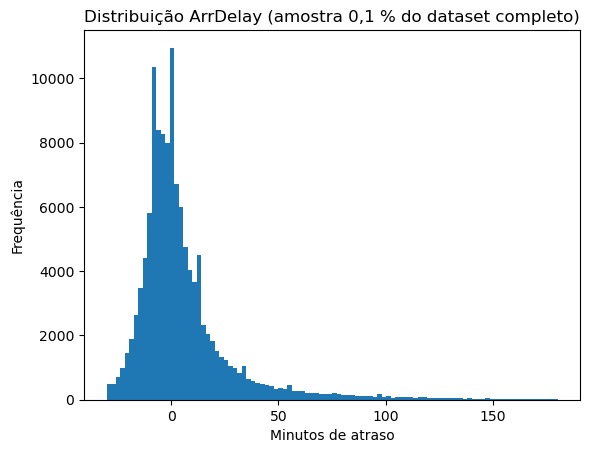

In [20]:
pdf = (sample_carrier
       .select("ArrDelay")
       .sample(fraction=0.01, seed=1)    # 1 % da amostra = ~120k linhas
       .toPandas())

plt.hist(pdf["ArrDelay"], bins=100, range=(-30, 180))
plt.title("Distribuição ArrDelay (amostra 0,1 % do dataset completo)")
plt.xlabel("Minutos de atraso")
plt.ylabel("Frequência")
plt.show()

### Boxplot de atraso por companhia

<Figure size 1200x600 with 0 Axes>

<Axes: title={'center': 'ArrDelay'}, xlabel='UniqueCarrier'>

Text(0.5, 0.98, '')

Text(0.5, 1.0, 'ArrDelay por companhia (amostra)')

Text(0, 0.5, 'Minutos')

<Figure size 1200x600 with 0 Axes>

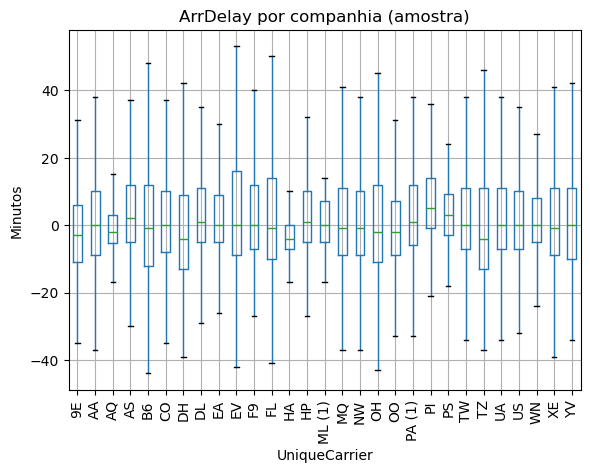

In [21]:
pdf2 = (sample_carrier
        .select("UniqueCarrier", "ArrDelay")
        .sample(fraction=0.01, seed=2)    # reduz ainda mais
        .toPandas())

plt.figure(figsize=(12,6))
pdf2.boxplot(column="ArrDelay", by="UniqueCarrier", rot=90, showfliers=False)
plt.suptitle("")
plt.title("ArrDelay por companhia (amostra)")
plt.ylabel("Minutos")
plt.show()

### Atraso médio ao longo do ano

+-----+-------------+--------+
|Month|UniqueCarrier|mean_arr|
+-----+-------------+--------+
|1    |9E           |10.28   |
|1    |AA           |7.51    |
|1    |AQ           |0.1     |
|1    |AS           |8.71    |
|1    |B6           |9.68    |
|1    |CO           |8.04    |
|1    |DH           |11.42   |
|1    |DL           |9.06    |
|1    |EA           |11.24   |
|1    |EV           |7.04    |
|1    |F9           |6.97    |
|1    |FL           |9.09    |
|1    |HA           |-1.08   |
|1    |HP           |8.69    |
|1    |ML (1)       |17.2    |
|1    |MQ           |9.88    |
|1    |NW           |6.72    |
|1    |OH           |7.81    |
|1    |OO           |11.31   |
|1    |PA (1)       |6.42    |
|1    |PI           |12.29   |
|1    |PS           |6.07    |
|1    |TW           |10.68   |
|1    |TZ           |11.12   |
|1    |UA           |9.9     |
|1    |US           |6.8     |
|1    |WN           |5.9     |
|1    |XE           |8.18    |
|1    |YV           |10.85   |
|2    |9

<Figure size 1200x600 with 0 Axes>

<Axes: ylabel='Month'>

Text(0.5, 1.0, 'Atraso médio (min) por Mês e Companhia — amostra 10 %')

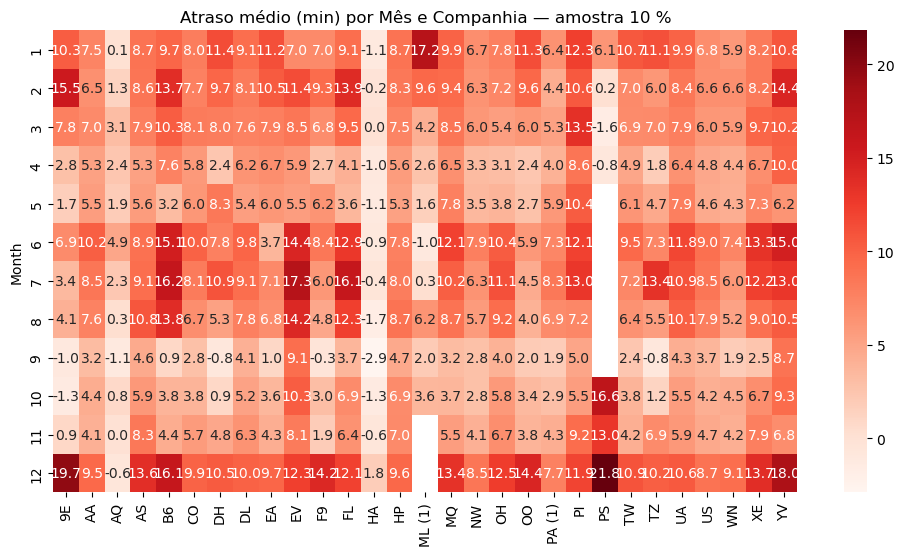

In [22]:
(sample_carrier
   .groupBy("Month", "UniqueCarrier")
   .agg(ps_round(avg("ArrDelay"), 2).alias("mean_arr"))
   .orderBy("Month", "UniqueCarrier")
   .show(60, truncate=False))

pivot_df = (sample_carrier
            .groupBy("Month")
            .pivot("UniqueCarrier")           # cria coluna para cada empresa
            .agg(ps_round(avg("ArrDelay"), 1))   # média de atraso
            .orderBy("Month"))

pivot_df.show(truncate=False)

pdf = pivot_df.toPandas().set_index("Month").sort_index()
plt.figure(figsize=(12,6))
sns.heatmap(pdf, annot=True, fmt=".1f", cmap="Reds")
plt.title("Atraso médio (min) por Mês e Companhia — amostra 10 %")
plt.show()

### Heatmap Origin × Dest com maior atraso

+------+----+------------------+-------+
|Origin|Dest|mean_arr          |flights|
+------+----+------------------+-------+
|BGR   |EWR |33.82520325203252 |246    |
|EWR   |LIT |33.808383233532936|167    |
|MSN   |EWR |31.42452830188679 |212    |
|JAC   |ORD |30.881720430107528|279    |
|GUC   |DFW |30.228571428571428|245    |
|CEC   |SFO |29.091525423728815|295    |
|EWR   |BQN |28.79475982532751 |229    |
|LEX   |EWR |28.633333333333333|180    |
|ACY   |ATL |27.96153846153846 |104    |
|HDN   |ORD |26.51101321585903 |227    |
|GRR   |EWR |25.68059701492537 |335    |
|EWR   |LEX |25.436274509803923|204    |
|IAD   |BHM |25.31654676258993 |139    |
|ATL   |HHH |25.218446601941746|206    |
|GRB   |MQT |24.857142857142858|154    |
|SDF   |EWR |24.837481698389457|683    |
|DAL   |LGA |24.623762376237625|101    |
|PNS   |ORD |23.94326241134752 |141    |
|MKE   |EWR |23.853131749460044|926    |
|RAP   |ORD |23.672897196261683|107    |
+------+----+------------------+-------+



<Axes: xlabel='Dest', ylabel='Origin'>

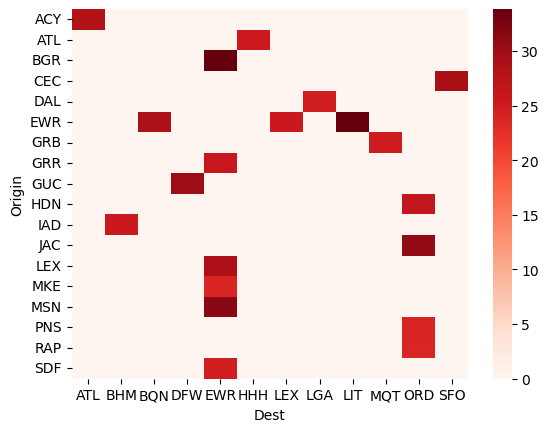

In [23]:
top_routes = (sample_carrier
              .groupBy("Origin", "Dest")
              .agg(avg("ArrDelay").alias("mean_arr"), count("*").alias("flights"))
              .filter("flights > 100")           # ignora rotas raras
              .orderBy("mean_arr", ascending=False)
              .limit(20))

top_routes.show(truncate=False)

pdf_heat = (top_routes.select("Origin","Dest","mean_arr").toPandas()
            .pivot(index="Origin", columns="Dest", values="mean_arr")
            .fillna(0))

sns.heatmap(pdf_heat, cmap="Reds")


### Cancelamentos e desvio

In [24]:
(stats_cancel := sample_carrier
    .select(expr("100*avg(Cancelled)  as pct_cancelados"),
            expr("100*avg(Diverted)   as pct_desrtidos"))).show()

(sample_carrier.groupBy("UniqueCarrier")
               .agg(ps_round(100*avg("Cancelled"),2).alias("%_cancel"),
                    ps_round(100*avg("Diverted"),2).alias("%_divert"))
               .orderBy("%_cancel", ascending=False)
               .show())

+------------------+-------------------+
|    pct_cancelados|      pct_desrtidos|
+------------------+-------------------+
|1.8658164765053307|0.22862093212075535|
+------------------+-------------------+

+-------------+--------+--------+
|UniqueCarrier|%_cancel|%_divert|
+-------------+--------+--------+
|           MQ|    3.95|    0.19|
|           YV|    3.44|    0.17|
|           OH|    3.17|    0.17|
|           DH|    3.15|    0.16|
|           EA|    3.06|    0.81|
|           9E|    2.99|    0.29|
|           EV|    2.86|    0.19|
|           XE|    2.22|    0.32|
|           UA|    2.18|    0.23|
|           OO|    2.13|    0.16|
|           NW|     2.1|    0.25|
|           US|    2.09|    0.22|
|           AS|    1.98|    0.38|
|           AA|     1.9|    0.27|
|           TW|    1.84|    0.28|
|       ML (1)|    1.82|     0.2|
|           AQ|    1.82|     0.0|
|           DL|    1.57|    0.17|
|           HP|    1.51|    0.15|
|           PS|    1.38|    0.14|
+-----------

<Figure size 1200x1000 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f637107d210>,
 [Text(0, 0, 'ActualElapsedTime'),
  Text(1, 0, 'AirTime'),
  Text(2, 0, 'ArrDelay'),
  Text(3, 0, 'ArrTime'),
  Text(4, 0, 'CRSArrTime'),
  Text(5, 0, 'CRSDepTime'),
  Text(6, 0, 'CRSElapsedTime'),
  Text(7, 0, 'Cancelled'),
  Text(8, 0, 'CarrierDelay'),
  Text(9, 0, 'DayOfWeek'),
  Text(10, 0, 'DayofMonth'),
  Text(11, 0, 'DepDelay'),
  Text(12, 0, 'DepTime'),
  Text(13, 0, 'Distance'),
  Text(14, 0, 'Diverted'),
  Text(15, 0, 'FlightNum'),
  Text(16, 0, 'LateAircraftDelay'),
  Text(17, 0, 'NASDelay'),
  Text(18, 0, 'SecurityDelay'),
  Text(19, 0, 'TaxiIn'),
  Text(20, 0, 'TaxiOut'),
  Text(21, 0, 'WeatherDelay'),
  Text(22, 0, 'Year'),
  Text(23, 0, 'Month'),
  Text(24, 0, 'IsArrDelay'),
  Text(25, 0, 'IsDepDelay'),
  Text(26, 0, 'CarrierDelay_missing'),
  Text(27, 0, 'WeatherDelay_missing'),
  Text(28, 0, 'NASDelay_missing'),
  Text(29, 0, 'SecurityDelay_missing'),
  Text(30, 0, 'LateAircraftDelay_missing'),
  Text(31, 0, 'TaxiIn_missing

([<matplotlib.axis.YTick at 0x7f6371090d90>,
 [Text(0, 0, 'ActualElapsedTime'),
  Text(0, 1, 'AirTime'),
  Text(0, 2, 'ArrDelay'),
  Text(0, 3, 'ArrTime'),
  Text(0, 4, 'CRSArrTime'),
  Text(0, 5, 'CRSDepTime'),
  Text(0, 6, 'CRSElapsedTime'),
  Text(0, 7, 'Cancelled'),
  Text(0, 8, 'CarrierDelay'),
  Text(0, 9, 'DayOfWeek'),
  Text(0, 10, 'DayofMonth'),
  Text(0, 11, 'DepDelay'),
  Text(0, 12, 'DepTime'),
  Text(0, 13, 'Distance'),
  Text(0, 14, 'Diverted'),
  Text(0, 15, 'FlightNum'),
  Text(0, 16, 'LateAircraftDelay'),
  Text(0, 17, 'NASDelay'),
  Text(0, 18, 'SecurityDelay'),
  Text(0, 19, 'TaxiIn'),
  Text(0, 20, 'TaxiOut'),
  Text(0, 21, 'WeatherDelay'),
  Text(0, 22, 'Year'),
  Text(0, 23, 'Month'),
  Text(0, 24, 'IsArrDelay'),
  Text(0, 25, 'IsDepDelay'),
  Text(0, 26, 'CarrierDelay_missing'),
  Text(0, 27, 'WeatherDelay_missing'),
  Text(0, 28, 'NASDelay_missing'),
  Text(0, 29, 'SecurityDelay_missing'),
  Text(0, 30, 'LateAircraftDelay_missing'),
  Text(0, 31, 'TaxiIn_missing

Text(0.5, 1.0, 'Correlation heat‑map – Spark ML (no pandas)')

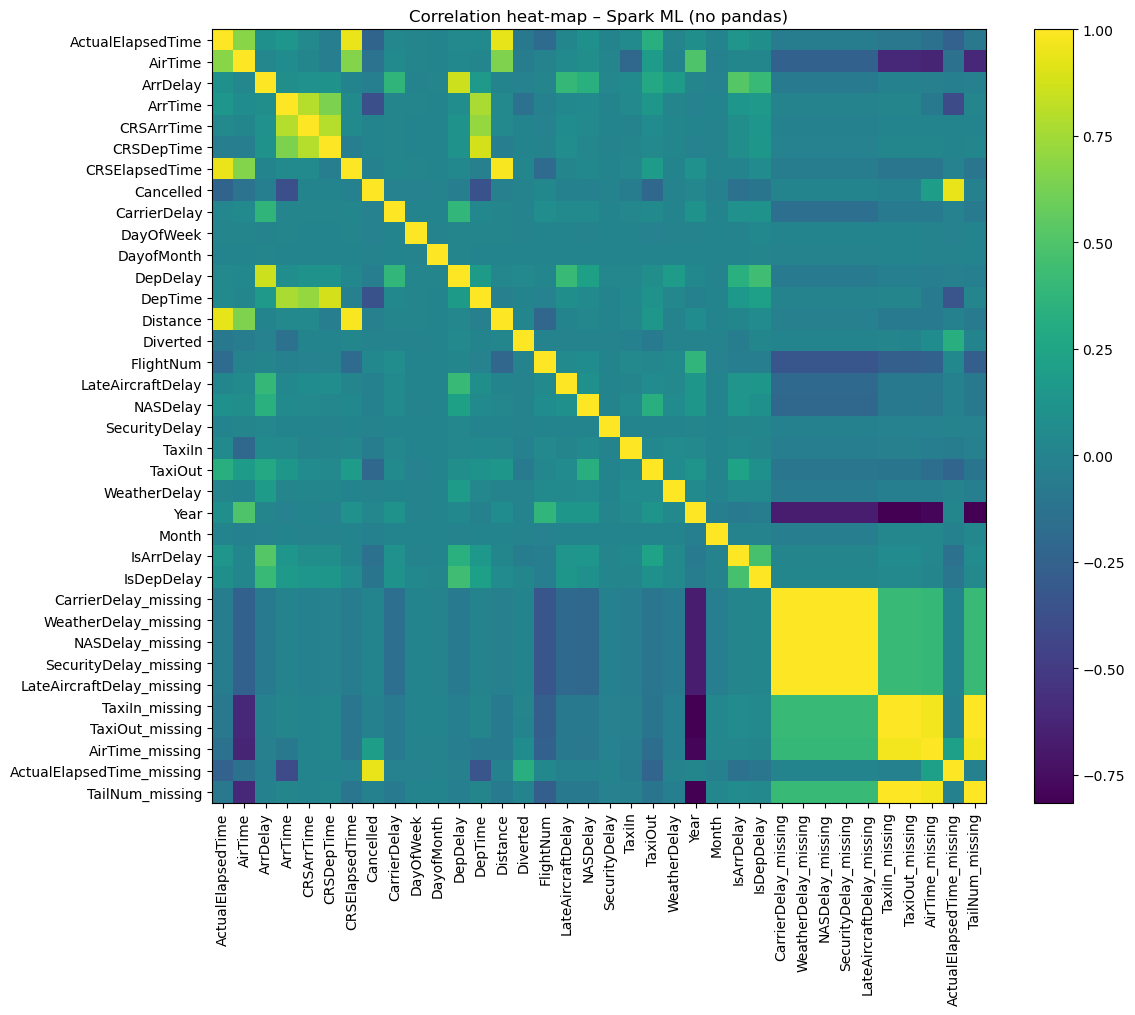

In [25]:
# colunas numéricas
numeric_cols = [f.name for f in sample_carrier.schema.fields
                if isinstance(f.dataType, NumericType)]

# remover linhas com nulos nessas colunas
numeric_df = sample_carrier.select(numeric_cols).na.drop()

# criar coluna vetorial
vec_assembler = VectorAssembler(inputCols=numeric_cols,
                                outputCol="vec",
                                handleInvalid="skip")
vec_df = vec_assembler.transform(numeric_df).select("vec")

# matriz de correlação distribuída (pearson)
corr_matrix = (Correlation.corr(vec_df, "vec", "pearson")
                          .head()[0]          
                          .toArray())        

# plot heat‑map
plt.figure(figsize=(12, 10))
plt.imshow(corr_matrix, interpolation="nearest") 
plt.colorbar()
plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=90)
plt.yticks(range(len(numeric_cols)), numeric_cols)
plt.title("Correlation heat‑map – Spark ML (no pandas)")
plt.tight_layout()
plt.show()


## Entendendo os padrões

In [26]:
# Encontrando o delay médio por dia

delay = sample_carrier.filter(col("ArrDelay") > 0)

mean_delay_per_day = delay.groupBy("DayOfWeek") \
    .agg(avg("ArrDelay").alias("AvgDelay")) \
    .orderBy(desc("AvgDelay"))

df_days = mean_delay_per_day.withColumn(
    "WeekdayName",
    when(col("DayOfWeek") == 1, "Domingo")
    .when(col("DayOfWeek") == 2, "Segunda")
    .when(col("DayOfWeek") == 3, "Terça")
    .when(col("DayOfWeek") == 4, "Quarta")
    .when(col("DayOfWeek") == 5, "Quinta")
    .when(col("DayOfWeek") == 6, "Sexta")
    .when(col("DayOfWeek") == 7, "Sábado")
)

df_days.orderBy(desc("AvgDelay")).show()

+---------+------------------+-----------+
|DayOfWeek|          AvgDelay|WeekdayName|
+---------+------------------+-----------+
|        5|25.707316889628512|     Quinta|
|        4| 24.96412852524226|     Quarta|
|        7| 24.06855295109978|     Sábado|
|        1|23.698088418760808|    Domingo|
|        3| 23.55290067193685|      Terça|
|        2|22.698229059342047|    Segunda|
|        6| 22.10535076250098|      Sexta|
+---------+------------------+-----------+



+-----+------------------+------------------+
|Month|num_voos_atrasados|      media_atraso|
+-----+------------------+------------------+
|   12|            551724|10.195638047005875|
|    6|            510790| 9.548177637221164|
|    7|            507422| 8.606388565340438|
|    8|            505496| 7.602428885320158|
|    3|            497758|  7.14081204740181|
|    1|            494572| 8.131471806320153|
|   10|            482696|  4.61372789402703|
|   11|            466329| 5.226666262445687|
|    5|            460347| 5.388027011168154|
|    2|            455574| 7.669328938293128|
|    4|            452072| 5.202365274898453|
|    9|            400079| 3.299391759188745|
+-----+------------------+------------------+



<BarContainer object of 12 artists>

Text(0.5, 0, 'Mês')

Text(0, 0.5, 'Voos com atraso (ArrDelay > 0)')

Text(0.5, 1.0, 'Volume de atrasos por mês – amostra 10 %')

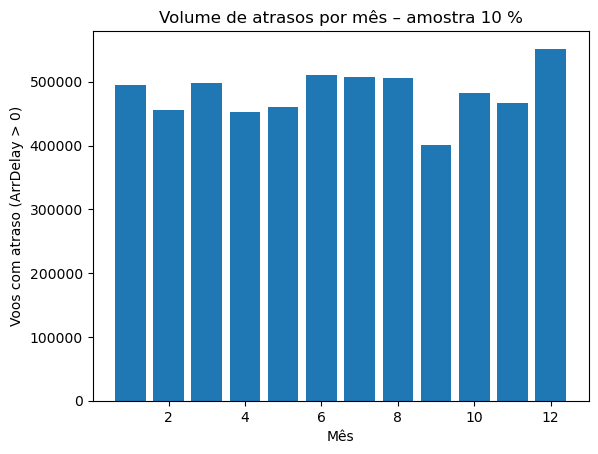

In [27]:
# total de voos atrasados por mês
atrasados = (sample_carrier
             .filter(col("ArrDelay") > 0)
             .groupBy("Month")
             .agg(count("*").alias("num_voos_atrasados")))

# atraso médio por mês
media = (sample_carrier
         .groupBy("Month")
         .agg(avg("ArrDelay").alias("media_atraso")))

# juntar e ordenar
resultado = (atrasados
             .join(media, "Month")
             .orderBy(col("num_voos_atrasados").desc())) 

resultado.show()

pdf = (resultado
       .toPandas()
       .sort_values("Month"))

plt.bar(pdf["Month"], pdf["num_voos_atrasados"])
plt.xlabel("Mês")
plt.ylabel("Voos com atraso (ArrDelay > 0)")
plt.title("Volume de atrasos por mês – amostra 10 %")
plt.show()

In [28]:
# Aeroportos de origem e destino com mais atrasos
min_voos = 300     # quantidade minima de voos

top10_origem = (
    sample_carrier      
    .filter(col("DepDelay") > 0)
    .groupBy("Origin")
    .agg(count("*").alias("num_atrasos"),
         ps_round(avg("DepDelay"), 1).alias("avg_dep_delay"))
    .filter(col("num_atrasos") >= min_voos)
    .orderBy(col("avg_dep_delay").desc())
    .limit(10)
)

top10_origem.show(truncate=False)

top10_dest = (
    sample_carrier      
    .filter(col("DepDelay") > 0)
    .groupBy("Dest")
    .agg(count("*").alias("num_atrasos"),
         ps_round(avg("DepDelay"), 1).alias("avg_dep_delay"))
    .filter(col("num_atrasos") >= min_voos)
    .orderBy(col("avg_dep_delay").desc())
    .limit(10)
)

top10_dest.show(truncate=False)

+------+-----------+-------------+
|Origin|num_atrasos|avg_dep_delay|
+------+-----------+-------------+
|EGE   |797        |46.0         |
|BMI   |676        |42.8         |
|HDN   |596        |42.6         |
|ATW   |666        |42.4         |
|ASE   |497        |42.1         |
|AEX   |437        |42.0         |
|YAK   |458        |41.8         |
|XNA   |2697       |41.1         |
|WRG   |484        |39.9         |
|SJT   |314        |39.1         |
+------+-----------+-------------+

+----+-----------+-------------+
|Dest|num_atrasos|avg_dep_delay|
+----+-----------+-------------+
|GUM |345        |41.3         |
|YAK |551        |40.6         |
|PSG |601        |40.5         |
|VLD |310        |40.0         |
|CDV |551        |38.3         |
|CWA |327        |37.2         |
|DHN |422        |36.5         |
|BMI |970        |36.5         |
|BRW |374        |36.1         |
|ATW |883        |35.8         |
+----+-----------+-------------+



In [30]:
min_voos = 300        # só TailNum com >= 300 voos (ajuste conforme tamanho do dado)

# número de voos atrasados por TailNum
top_freq = (
    df_raw.filter(col("ArrDelay") > 0)
          .groupBy("TailNum")
          .agg(count("*").alias("num_atrasos"))
          .filter(col("num_atrasos") >= min_voos)
          .orderBy(col("num_atrasos").desc())
          .limit(10)
)

print("TailNum por quantidade de atrasos")
top_freq.show(truncate=False)

# soma total de minutos de atraso
top_sum = (
    df_raw.filter(col("ArrDelay") > 0)
          .groupBy("TailNum")
          .agg(ps_sum("ArrDelay").alias("soma_min_atraso"))
          .filter(col("soma_min_atraso") > 0)
          .orderBy(col("soma_min_atraso").desc())
          .limit(10)
)

print("TailNum por soma total (minutos) de atraso")
top_sum.show(truncate=False)

# atraso médio (min) – útil para ver 'pior' desempenho
top_avg = (
    df_raw.groupBy("TailNum")
          .agg(ps_round(avg("ArrDelay"),1).alias("media_atraso"),
               count("*").alias("num_voos"))
          .filter(col("num_voos") >= min_voos)
          .orderBy(col("media_atraso").desc())
          .limit(10)
)

print("TailNum por atraso médio")
top_avg.show(truncate=False)

TailNum por quantidade de atrasos
+-------+-----------+
|TailNum|num_atrasos|
+-------+-----------+
|UNKN   |19132778   |
|N320   |14910      |
|N526   |14902      |
|N678   |14874      |
|N332   |14834      |
|N336   |14820      |
|N325   |14809      |
|N675   |14787      |
|N322   |14765      |
|N337   |14751      |
+-------+-----------+

TailNum por soma total (minutos) de atraso
+-------+---------------+
|TailNum|soma_min_atraso|
+-------+---------------+
|UNKN   |348048483      |
|N381UA |404651         |
|N375UA |401958         |
|N366UA |392336         |
|N377UA |389688         |
|N374UA |378894         |
|N385UA |378074         |
|N386UA |376511         |
|N369UA |376194         |
|N367UA |374426         |
+-------+---------------+

TailNum por atraso médio
+-------+------------+--------+
|TailNum|media_atraso|num_voos|
+-------+------------+--------+
|N93104 |42.6        |381     |
|N133TW |41.4        |563     |
|N601US |37.7        |343     |
|N674US |36.1        |322     |


## Tratamento dos dados Categoricos

In [21]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import (
    StringIndexer, OneHotEncoder,
    FeatureHasher, VectorAssembler, StandardScaler
)

# ─────────── CONFIGURAÇÕES (fácil de alterar) ───────────
CAT_LOW   = ["CancellationCode", "UniqueCarrier"]    # cardinalidade < 30
CAT_MID   = ["Origin", "Dest"]                       # ~300 categorias
HASH_HIGH = ["TailNum", "Route"]                     # alta cardinalidade

NUM_COLS  = ["DepDelay", "Distance", "TaxiOut", "TaxiIn",
             "AirTime", "Month", "DayOfWeek"]        # numéricas finais

FLAG_MISS = ["AirTime", "DepDelay", "TaxiIn", "TaxiOut", "TailNum"]

USE_HASH_FOR_MID = False        # ↔ coloque True se quiser hashear Origin/Dest
HASH_DIM_MID     = 256
HASH_DIM_HIGH    = 256

# ─────────── CRIAÇÃO DOS STAGES ───────────
stages = []

# 1) Baixa cardinalidade  →  Index + One-Hot
for col_ in CAT_LOW:
    idx = StringIndexer(inputCol=col_, outputCol=f"{col_}_idx",
                        handleInvalid="keep")
    ohe = OneHotEncoder(inputCol=f"{col_}_idx", outputCol=f"{col_}_ohe",
                        dropLast=False)
    stages += [idx, ohe]

# 2) Média cardinalidade  →  OHE ou Hashing, conforme flag
if USE_HASH_FOR_MID:
    hasher_mid = FeatureHasher(
        inputCols=CAT_MID,
        outputCol="mid_hash",
        numFeatures=HASH_DIM_MID
    )
    stages.append(hasher_mid)
    MID_OUTPUT = ["mid_hash"]
else:
    for col_ in CAT_MID:
        idx = StringIndexer(inputCol=col_, outputCol=f"{col_}_idx",
                            handleInvalid="keep")
        ohe = OneHotEncoder(inputCol=f"{col_}_idx", outputCol=f"{col_}_ohe",
                            dropLast=False)
        stages += [idx, ohe]
    MID_OUTPUT = [f"{c}_ohe" for c in CAT_MID]

# Alta cardinalidade  →  FeatureHasher
hasher_high = FeatureHasher(
    inputCols=HASH_HIGH,
    outputCol="high_hash",
    numFeatures=HASH_DIM_HIGH
)
stages.append(hasher_high)

# VectorAssembler
assembler_inputs = (
      [f"{c}_ohe" for c in CAT_LOW]   # low-card OHE
    + MID_OUTPUT                      # mid OHE ou hash
    + ["high_hash"]                   # alta hash
    + NUM_COLS                        # numéricas
    + [f"{c}_missing" for c in FLAG_MISS]   # flags de ausência
)

assembler = VectorAssembler(
    inputCols=assembler_inputs,
    outputCol="features_raw"
)
stages.append(assembler)

# StandardScaler  (apenas para modelos lineares / redes)
scaler = StandardScaler(
    inputCol="features_raw",
    outputCol="features",
    withMean=False      # mantém esparso
)
stages.append(scaler)

# ─────────── PIPELINE FINAL ───────────
fe_pipeline = Pipeline(stages=stages)

# ─────────── FIT / TRANSFORM EXEMPLO ───────────
# fe_model  = fe_pipeline.fit(df_raw)
# df_feats  = fe_model.transform(df_raw).select("features", "ArrDelay")

# Agora df_feats está pronto para RandomForest, GBT, regressão linear etc.

A maior taxa média de atraso se dá nas quintas-feiras como podemos observar.

# Model

In [25]:
gbt = GBTRegressor(featuresCol = "features",
                  labelCol = "ArrDelay",
                  maxDepth = 8, maxIter = 80)
stages.append(gbt)

pipeline = Pipeline(stages = stages)

In [26]:
train, test = df_model.randomSplit([0.8, 0.2], seed=42)

model = pipeline.fit(train)

pred = model.transform(test)
evaluator = RegressionEvaluator(labelCol="ArrDelay",
                                predictionCol="prediction",
                                metricName="rmse")
print("RMSE =", evaluator.evaluate(pred))

NameError: name 'df_model' is not defined